# **Image segmentation by foundation model finetuning**
## **I-GUIDE Summer School Team 6: Team Awesome**

*Boulder, Colorado. Monday Aug 7 – Friday Aug 11, 2023.*

**Last Updated:** 10.15.2023
<hr>

## Meet the Team
- **Claire Simpson**, University of Colorado, Boulder  (Claire.simpson@colorado.edu)
- **Jiyoung Lee**, Louisiana State University (jlee257@lsu.edu)
- **Salar Jarhan**, University of Wyoming (Sjarhan@uwyo.edu)
- **Yalin Yang**, University of Texas, Dellas (yxy180050@utdallas.edu)
- **Yanhong Huang**, University of New Mexico (huangyh0906@unm.edu)


## Team Advisors
- **Dr. Diana Sinton**, University Consortium for Geographic Information Science (dsinton@ucgis.org)
- **Dr. Eric Shook**, University of Minnesota (eshook@umn.edu)
- **Dr. Rajesh Kalynam**, Purdue University (rkalyana@purdue.edu)

<hr>

As of August 03, 2023, [NASA and IBM announced a large GeoAI Foundation Model](https://www.earthdata.nasa.gov/news/impact-ibm-hls-foundation-model), using Harmonized Landsat and Sentinel-2 ([HSL](https://www.earthdata.nasa.gov/esds/harmonized-landsat-sentinel-2)) data. We migrated the foundation model over [I-GUIDE](https://iguide.illinois.edu/) and fine tuned the model.

This documentaion shows three examples of how Prithvi can be finetuned for downstream tasks. The examples include [*burn scars detection*](#burn-scars-model) using the NASA HLS fire scars dataset, [*multi-temporal crop classification*](#multi-temporal-crop) using the NASA HLS multi-temporal crop classification dataset, and [*flood detection*](#flood-model) using Sentinel-2 data from the Sen1Floods11 dataset. We also developed [*our own model*](#NDBI) for detecting 'Build-up' and 'Non-build-up area' using the *NDBI (Normalized Difference Built-up Index)*.

## Table of Content<a name="Table-of-Content"></a>
- [Foundation Model](#foundation-model)
  - [The Architectures](#the-architectures)
  - [The Pipeline](#the-pipeline)
  - [Download the Demo](#download-the-demo)
  - [Dependencies](#dependencies)

- [Burn Scars Model](#burn-scars-model)
  - [Running the finetuning](#running-the-finetune-burn)
  - [Results](#results-burn)

- [Multi-Temporal Crop Classificaton Model](#multi-temporal-crop)
  - [Running the finetuning](#running-the-finetune-crop)
  - [Debugging Notes](#debugging-notes)
  - [Results](#results-crop)

- [Flood Model](#flood-model)
  - [Running the finetuning](#running-the-finetune-flood)
  - [Results](#results-flood)

- [Build up model base on NDBI](#NDBI)
  - [Running the finetuning](#running-the-finetune-NDBI)
  - [Results](#results-NDBI)


- [Data Science Ethics Checklist](#ethics)
- [Citation](#citation)

This notebook will serve as a comprehensive guide to our work with the GeoAI Foundation Model, its various applications, and the ethical considerations surrounding our data science efforts.


## **Foundation Model** <a name="foundation-model"></a>

[*Back to the table of content*](#Table-of-Content)

### **The architectures** <a name="the-architectures"></a>
We use a simple architecture that adds a neck and segmentation head to the backbone. The neck concatenates and processes the transformer's token based embeddings into an embedding that can be fed into convolutional layers. The head processes this embedding into a segmentation mask. The code for the architecture can be found in [this file](./geospatial_fm/geospatial_fm.py).

### **The pipeline** <a name="the-pipeline"></a>
Additionally, we provide extra components for data loading pipelines in [geospatial_pipelines.py](./geospatial_fm/geospatial_pipelines.py). These are documented in the file.
We observe the MMCV convention that all operations assumes a channel-last format. Our tiff loader also assumes this is the format in which files are written, and offers a flag to automatically transpose a to channel-last format if this is not the case.
*However*, we also introduce some components with the prefix `Torch`, such as `TorchNormalize`. These components assume the torch convention of channel-first.

At some point during the pipeline, before feeding the data to the model, it is necessary to change to channel-first format.
We reccomend implementing the change after the `ToTensor` operation (which is also necessary at some point), using the `TorchPermute` operation.

### **Download the demo** <a name="download-the-demo"></a>
Run the following cell to download the demo from the Hugging Face. It will colne the IBM NASA Geospatial demo and the model.



In [ ]:
# Install Git Large File Storage
!pip install git-lfs

# Clone Prithvi-100M-Demo
!git clone https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-demo

# Clone Prithvi-100M
!git clone https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M

### **Dependencies** <a name="dependencies"></a>

1. Clone this repository
2. `conda create -n <environment-name> python==3.9`
3. `conda activate <environment-name>`
4. Install torch (tested for >=1.7.1 and <=1.11.0) and torchvision (tested for >=0.8.2 and <=0.12). May vary with your system. Please check at: https://pytorch.org/get-started/previous-versions/.
    1. e.g.: `pip install torch==1.11.0+cu115 torchvision==0.12.0+cu115 --extra-index-url https://download.pytorch.org/whl/cu115`
5. `cd` into the cloned repo
5. `pip install -e .`
6. `pip install -U openmim`
7. `mim install mmcv-full==1.6.2 -f https://download.openmmlab.com/mmcv/dist/{cuda_version}/{torch_version}/index.html`. Note that pre-built wheels (fast installs without needing to build) only exist for some versions of torch and CUDA. Check compatibilities here: https://mmcv.readthedocs.io/en/v1.6.2/get_started/installation.html
    1. e.g.: `mim install mmcv-full==1.6.2 -f https://download.openmmlab.com/mmcv/dist/cu115/torch1.11.0/index.html`


## **Burn Scars Model** <a name="burn-scars-model"></a>

[*Back to the table of content*](#Table-of-Content)

The pretrained [Prithvi-100m](https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M/blob/main/README.md) parameter model is finetuned to detect Burn Scars on HLS data from the [HLS Burn Scar Scenes dataset](https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars). This dataset includes input tiles of 512x512x6, where 512 is the height and width and 6 is the number of bands. The bands are:

1. Blue
2. Green
3. Red
4. Narrow NIR
5. SWIR 1
6. SWIR 2   

It is important to point out that the HLS Burn Scar Scenes dataset includes a single timestep, while the Prithvi-100m was pretrained with three timesteps. The difference highlights the flexibility of this model to adapt to different downstream tasks and requirements.


The pretrained Prithvi-100m parameter model is finetuned to detect Burn Scars on HLS data from the HLS Burn Scar Scenes dataset. This dataset includes input tiles of 512x512x6, where 512 is the height and width and 6 is the number of bands. The bands are:

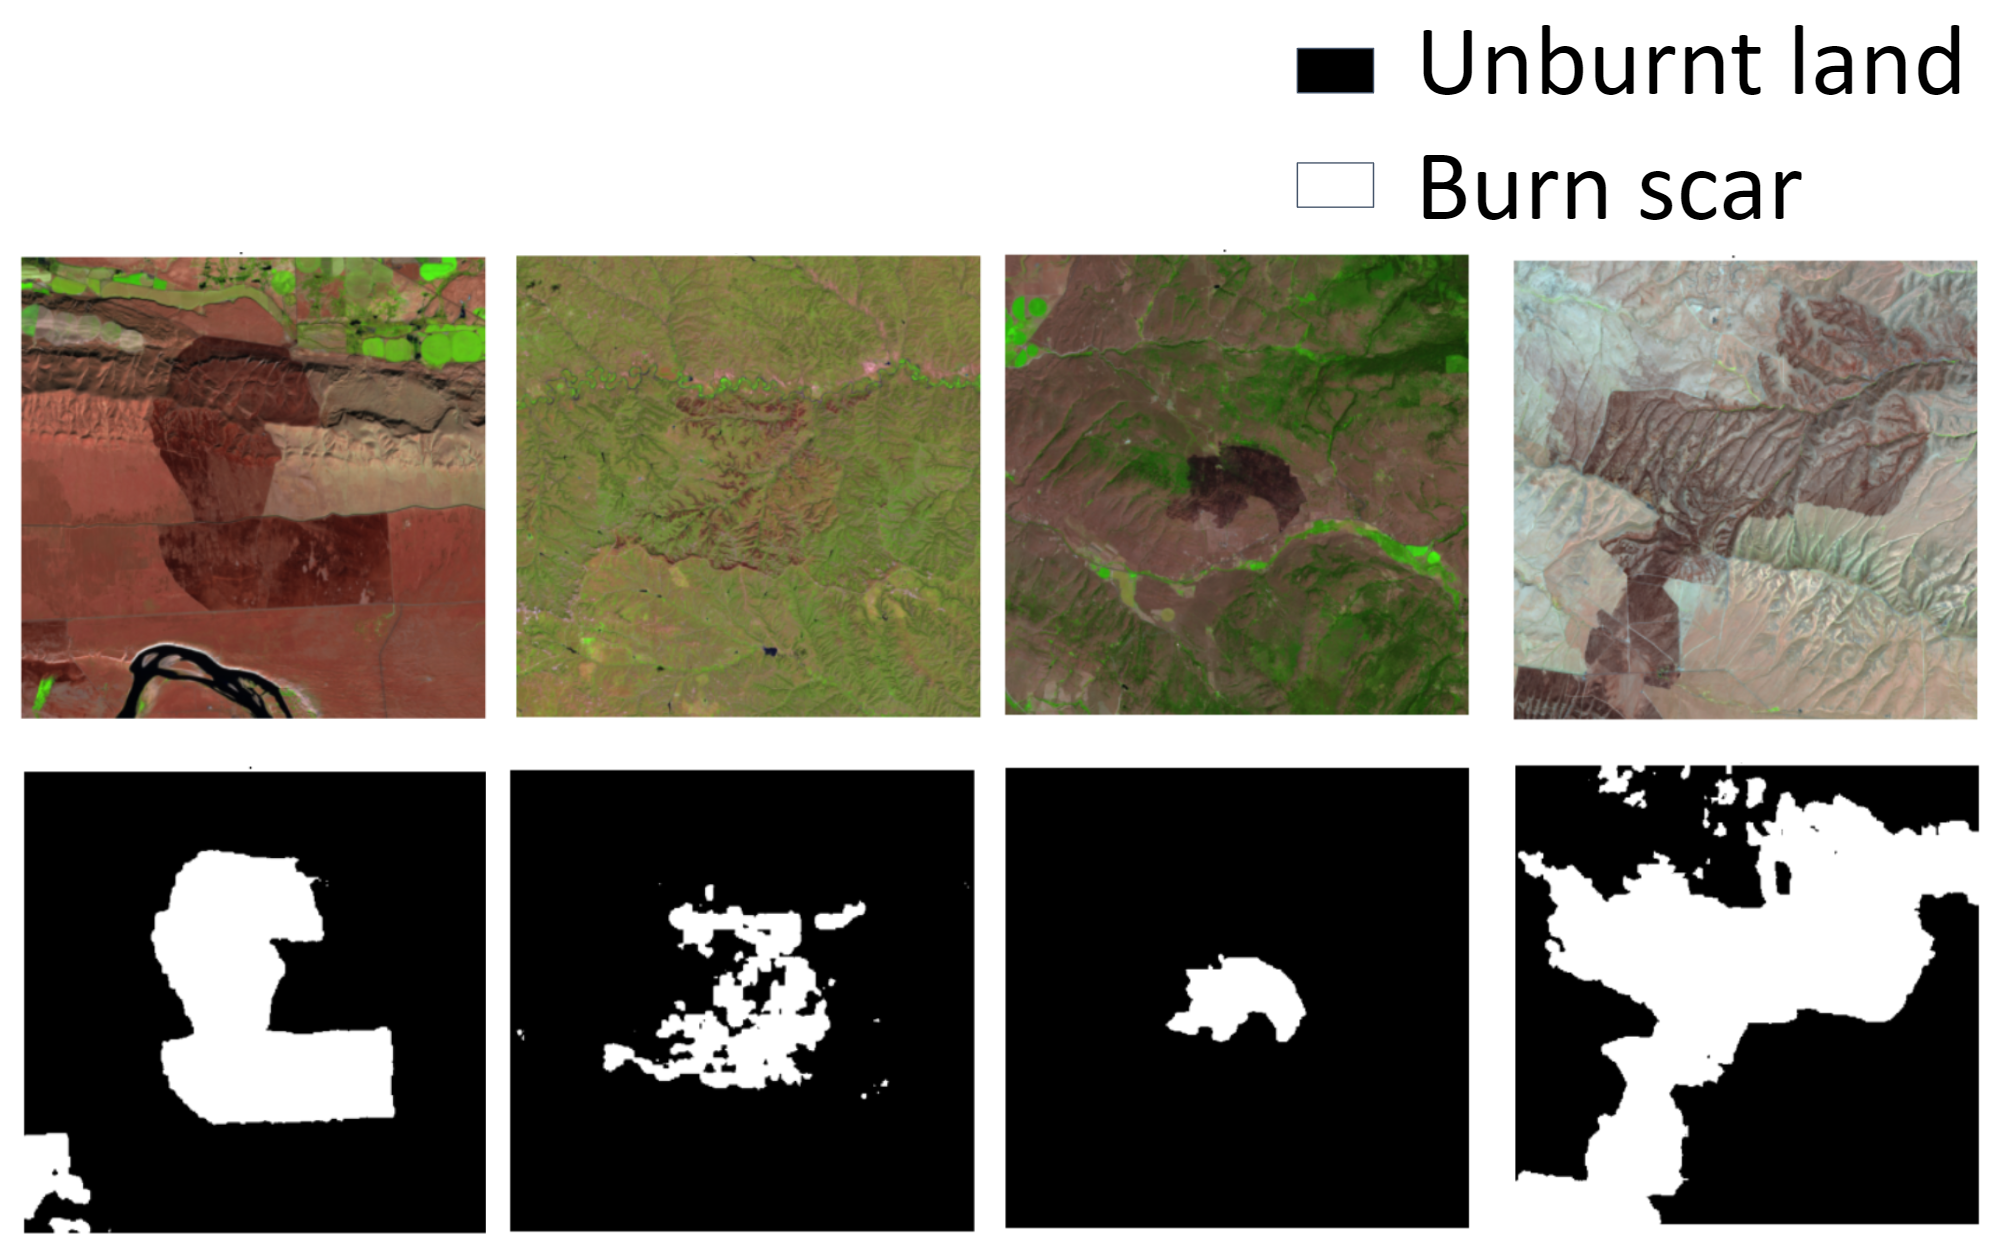



### **Running the finetuning** <a name="running-the-finetune-burn"></a>
* Images Downloading: the [NASA HLS fire scars dataset](https://huggingface.co/datasets/nasa-impact/hls_burn_scars) can be downloaded from Hugging Face.
    * `wget https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars/resolve/main/hls_burn_scars.tar.gz` to download the image dataset
    * `tar –xvzf hls_burn_scars.tar.gz` to unzip the image dataset
* In the `configs` folder there are three config examples for the three segmentation tasks. Complete the configs with your setup specifications. Parts that must be completed are marked with `#TO BE DEFINED BY USER`. They relate to the location where you downloaded the dataset, pretrained model weights, the test set (e.g. regular one or Bolivia out of bag data) and where you are going to save the experiment outputs.
    * Setup the input data: `data_root = "<path to data root directory>"`
    * Load the foundation model: `pretrained_weights_path = "<path to pretrained weights>"`
    * Set the model output: `experiment = "<experiment name>"; project_dir = "<project directory name>"`
* With the conda env created above activated, run:    
    *  `mim train mmsegmentation --launcher pytorch configs/burn_scars.py`         
* To run testing:      
    *  `mim test mmsegmentation configs/burn_scars.py --checkpoint /path/to/best/checkpoint/model.pth --eval "mIoU"`

### **Results** <a name="results-burn"></a>
The experiment conducted by running the mmseg stack for 50 epochs using the above config led to an IoU of **0.73** on the burn scar class and **0.96** overall accuracy. It is noteworthy that this leads to a reasonably good model, but further developement will most likely improve performance.


## **Multi-Temporal Crop Classificaton Model** <a name="multi-temporal-crop"></a>

[*Back to the table of content*](#Table-of-Content)

The pre-trained Prithvi-100M model can be fine-tuned to predict 12 crop/landcover types. This model differs from other fine-tuning tasks in that input data is multi-temporal, that is, inputs contain data from three different timesteps.            

Data for this task is stored on Hugging Face [here](https://huggingface.co/datasets/ibm-nasa-geospatial/multi-temporal-crop-classification). The dataset contains satellite imagery (Harmonized Landsat Sentinel-2 - HLS) GeoTIFFs, where each tif file is 224 x 224 pixels at 30m spatial resolution. Each input GeoTIFF contains 18 bands including 6 spectral bands for three time steps stacked together. That is, each GeoTIFF file effectively represents three images acquired over the same spatial location at threee different times. Each GeoTIFF file for the mask contains one band, where each pixel represents the target categorical class.

#### Input Bands:
In each input GeoTIFF the following bands are repeated three times for three observations throughout the growing season: Channel, Name, HLS S30 Band number
1. Blue, B02 (Image 1)
2. Green, B03 (Image 1)
3. Red, B04 (Image 1)
4. NIR, B8A (Image 1)
5. SWIR 1, B11 (Image 1)
6. SWIR 2, B12 (Image 1)
7. Blue, B02 (Image 2)
8. Green, B03 (Image 2)
9. Red, B04 (Image 2)
10. NIR, B8A (Image 2)
11. SW 1, B11 (Image 2)
12. SW 2, B121 (Image 2)
13. Blue, B02 (Image 3)
14. Green, B03 (Image 3)
15. Red, B04 (Image 3)
16. NIR, B8A (Image 3)
17. SW 1, B11 (Image 3)
18. SW 2, B12 (Image 3)

#### Output Classification:
Output images contain a single band with output class values:
- 0 : No Data
- 1 : Natural Vegetation
- 2 : Forest
- 3 : Corn
- 4 : Soybeans
- 5 : Wetlands
- 6 : Developed/Barren
- 7 : Open Water
- 8 : Winter Wheat
- 9 : Alfalfa
- 10 : Fallow/Idle Cropland
- 11 : Cotton
- 12 : Sorghum
- 13 : Other

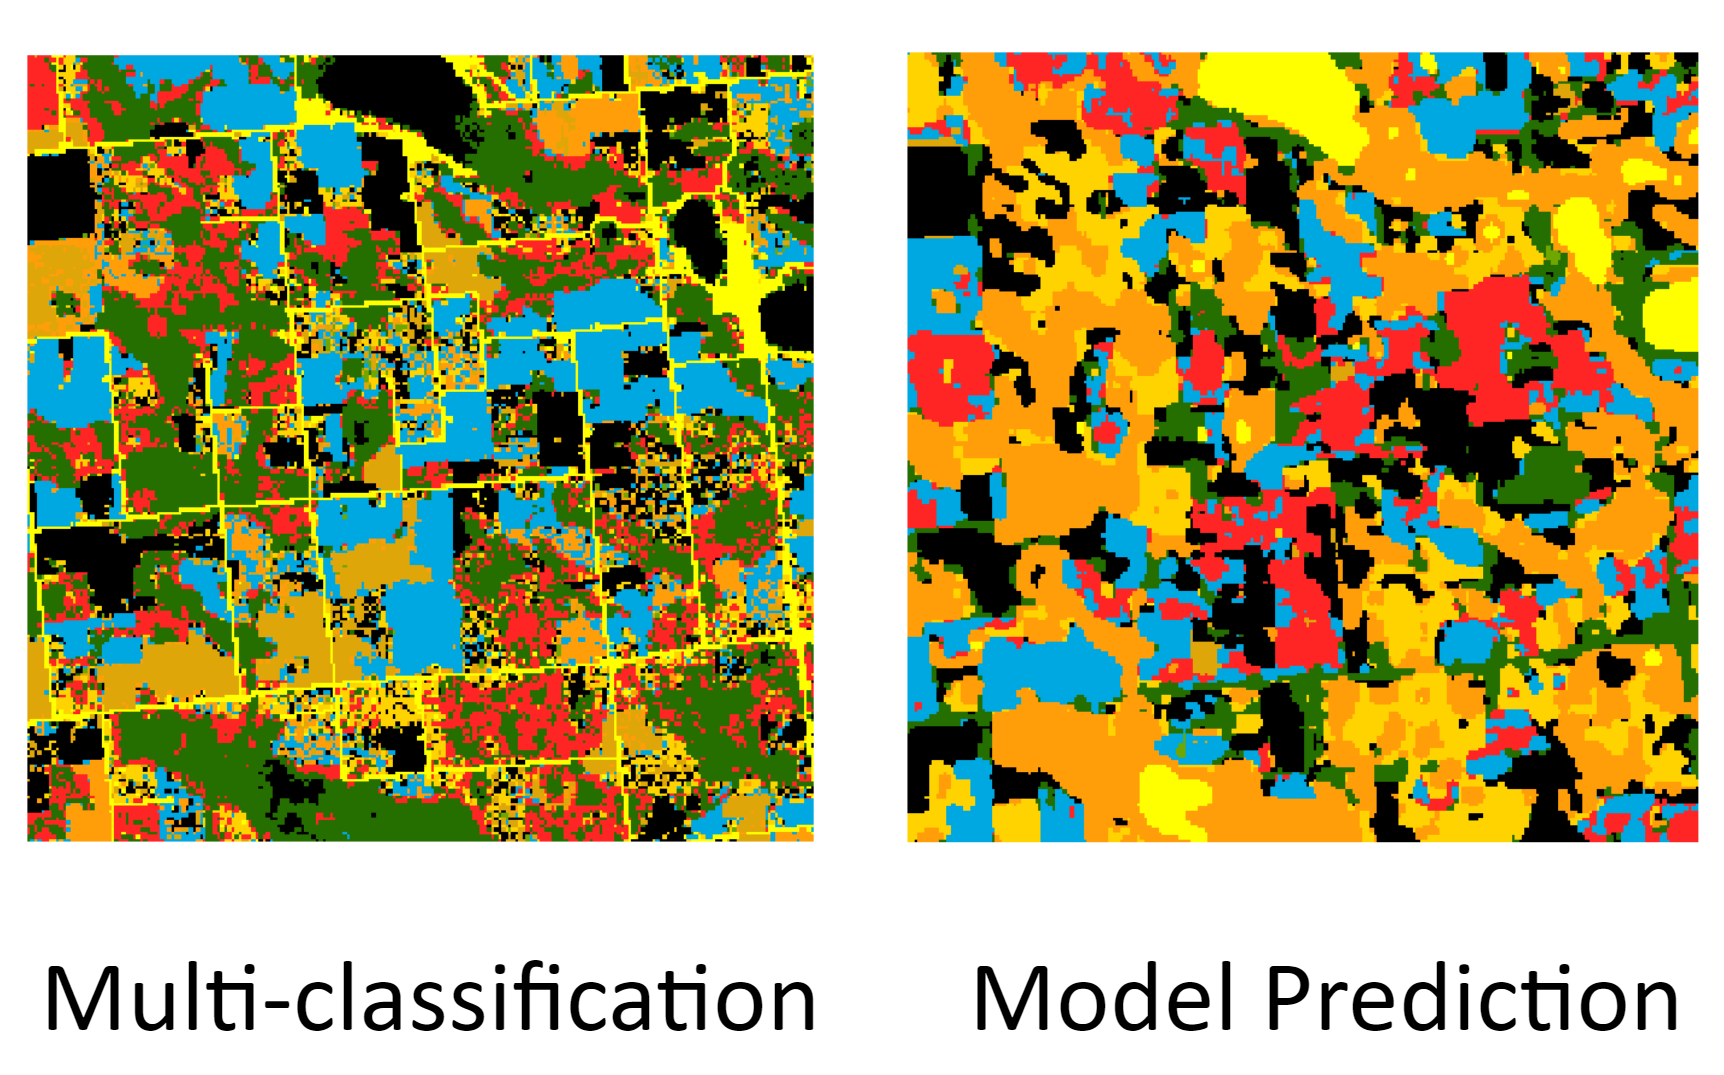



### **Running the finetuning** <a name="running-the-finetune-crop"></a>
We finetuned the foundational model for the task of crop classification by ssh-ing into a virtual machine with 1 GPU with 20 GB of memory. We followed these steps:

1. Download the data
    * `wget https://huggingface.co/datasets/ibm-nasa-geospatial/multi-temporal-crop-classification/resolve/main/training_chips.tgz` to download the training dataset
    * `wget https://huggingface.co/datasets/ibm-nasa-geospatial/multi-temporal-crop-classification/resolve/main/training_chips.txt` to download the training dataset file list
    * `wget https://huggingface.co/datasets/ibm-nasa-geospatial/multi-temporal-crop-classification/resolve/main/validation_chips.tgz` to download the validation dataset
    * `wget https://huggingface.co/datasets/ibm-nasa-geospatial/multi-temporal-crop-classification/resolve/main/validation_chips.txt` to download the validation dataset file list
    * `tar -xvf training_chips.tgz` to unzip the training image dataset
    * `tar -xvf validation_chips.tgz` to unzip the validation image dataset
    
    
2. In the `configs` folder, there is a python configuration file, `multi-temporal-crop-classification.py` Complete the configs with your setup specifications (marked with `#TO BE DEFINED BY USER`):
    * Setup the input data parent directory: `data_root = "<path to data root directory>"`
    * Specify subdirectories of train/test/validation data: `splits = dict(train='<path to train split>',val= '<path to val split>',test=  '<path to test split>')`
    * Use model weights from the foundation model: `pretrained_weights_path = "<path to pretrained weights>"`
    * Set the model output: `experiment = "<experiment name>"; project_dir = "<project directory name>"` (experiment is a subdirectory within the project directory)
    * **NOTE: We adjusted two parameters to solve memory issues: instead of `samples_per_gpu=8` and `workers_per_gpu=4`, we used `samples_per_gpu=4` and `worker_per_gpu=2`**

    
3. With the conda environment above activated, navigate to the hls-foundation-os folder and run:    
    *  `mim train mmsegmentation --launcher pytorch configs/multi-temporal-crop-classification.py`         
4. To run testing:      
    *  `mim test mmsegmentation configs/multi-temporal-crop-classification.py --checkpoint /path/to/best/checkpoint/model.pth --eval "mIoU"`

#### **Debugging Notes** <a name="debugging-notes"></a>

There is a bug when running model_inference on crop classification: The user needs to manually edit the `model_inference.py` to change from `axis=0` to `axis=-1` with the `def inference_on_file` function, or they will get a shape mismatch error here:


        `##### get metadata mask
        mask = open_tiff(target_image)
        meta = get_meta(target_image)
        mask = np.where(mask == meta['nodata'], 1, 0)
        mask = np.max(mask, axis=0)[None]`


Finally, ensure that input and output filepaths end with `/` to ensure that paths concatenate correctly and the scripts are able to find your data.

## **Flood model**  <a name="flood-model"></a>

[*Back to the table of content*](#Table-of-Content)

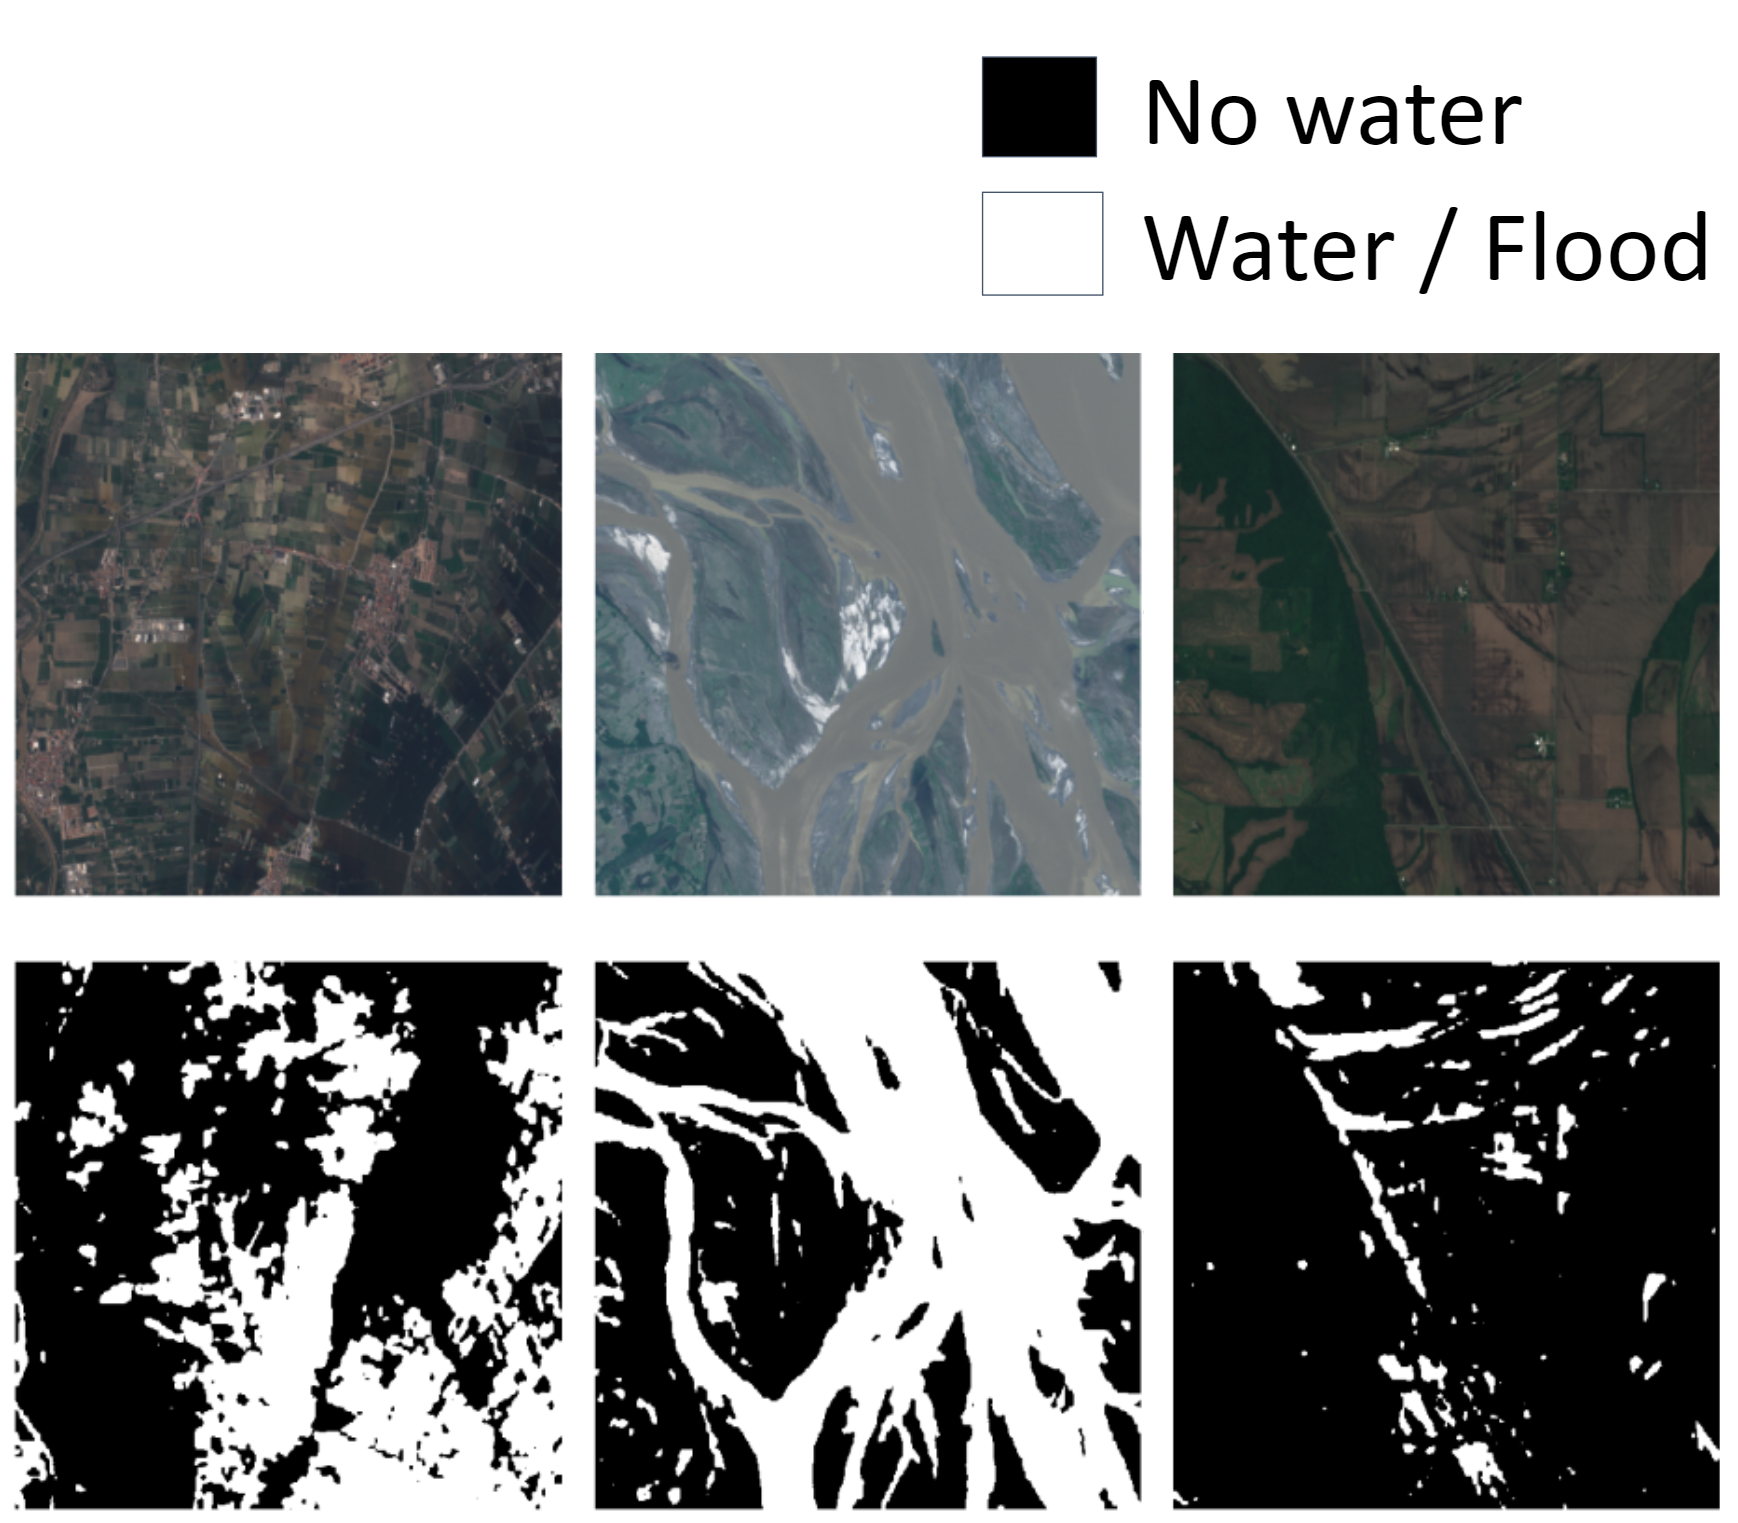

### **Running the finetuning** <a name="running-the-finetune-burn"></a>
* Images Downloading: the [NASA HandLabeled Flood dataset](https://github.com/cloudtostreet/Sen1Floods11#sen1floods11) can be downloaded using gsutil.
    * `gsutil -m rsync -r gs://sen1floods11 /home/jovyan/flood` to download the image dataset
    * `tar –xvzf hls_flood.tar.gz` to unzip the image dataset
* In the `configs` folder there are three config examples for the three segmentation tasks. Complete the configs with your setup specifications. Parts that must be completed are marked with `#TO BE DEFINED BY USER`. They relate to the location where you downloaded the dataset, pretrained model weights, the test set (e.g. regular one or Bolivia out of bag data) and where you are going to save the experiment outputs.
    * Setup the input data: `data_root = "<path to data root directory>"`
    * Load the foundation model: `pretrained_weights_path = "<path to pretrained weights>"`
    * Set the model output: `experiment = "<experiment name>"; project_dir = "<project directory name>"`
* With the conda env created above activated, run:    
    *  `mim train mmsegmentation --launcher pytorch configs/flood.py`         
* To run testing:      
    *  We can run inference on the new data in GeoTIFF format. The data can be of any shape (e.g. height and width) as long as it follows the bands/channels of the original dataset. An example is shown below.
```cmd
python model_inference.py -config /path/to/config/config.py -ckpt /path/to/checkpoint/checkpoint.pth -input /input/folder/ -output /output/folder/ -input_type tif -bands "[0,1,2,3,4,5]"
```
* In our case, `python model_inference.py -config /home/jovyan/hls-foundation-os/configs/sen1floods11_config.py -ckpt /home/jovyan/finetuned-models/best_mIoU_epoch_100.pth -input /home/jovyan/flood/input/ -output /home/jovyan/flood/out/ -input_type tif`


## **Build up model base on NDBI** <a name="NDBI"></a>

[*Back to the table of content*](#Table-of-Content)

The pretrained Prithvi-100m parameter model is finetuned to detect build up area on Sen1Floods11 data from the https://github.com/cloudtostreet/Sen1Floods11. The dataset includes size of 512x512 with 6 bands which are:

1. Blue
2. Green
3. Red
4. Narrow NIR
5. SWIR 1
6. SWIR 2   

Narrow NIR and SWIR1 were used to calculate NDBI index (https://doi.org/10.1007/s11356-020-11007-4) in order to build this model. For detecting the threshold, Otu's method (http://www.labbookpages.co.uk/software/imgProc/otsuThreshold.html) was used then the mask data was generated using the code below:



In [ ]:
# Implimentation of Otu's method to calculate NDBI index
import rasterio
import numpy as np
import glob
import os

dir_path = '/path/to/directory/'
file_pattern = os.path.join(dir_path, '*.tif')
lst = glob.glob(file_pattern)


th=[]
for k in range(len(lst)):
    input_file = lst[k]
    base_name = os.path.basename(input_file)
    base_name = base_name.replace("merged", "mask")

    # Load the GeoTIFF file
    with rasterio.open(input_file) as src:
        # Read the NIR and SWIR bands
        NIR = src.read(4)
        SWIR = src.read(5)

        # Calculate the NDBI index
        NDBI = (SWIR - NIR) / (SWIR + NIR)
        #NDBI[np.isnan(NDBI)] = 0

        # Calculate histogram
        histData = np.zeros(256, dtype=int)
        for pixel_value in NDBI.flatten():
            if pixel_value >= -1 and pixel_value <= 1:  # Check if pixel_value is within the range [-1, 1]
                h = int((pixel_value + 1) * 127.5)  # Mapping from [-1, 1] to [0, 255]
                histData[h] += 1

        # Total number of pixels
        total = NDBI.size

        sum_vals = np.sum(np.arange(256) * histData)

        sumB = 0
        wB = 0
        wF = 0

        varMax = 0
        threshold = 0

        for t in range(256):
            wB += histData[t]  # Weight Background
            if wB == 0:
                continue

            wF = total - wB  # Weight Foreground
            if wF == 0:
                break

            sumB += t * histData[t]

            mB = sumB / wB  # Mean Background
            mF = (sum_vals - sumB) / wF  # Mean Foreground

            # Calculate Between Class Variance
            varBetween = wB * wF * (mB - mF) * (mB - mF)

            # Check if new maximum found
            if varBetween > varMax:
                varMax = varBetween
                threshold = t

        # Apply the threshold to the NDBI index
        segmented = np.where(NDBI >= (threshold - 127.5) / 127.5, 1, (np.where(NDBI < (threshold - 127.5) / 127.5, 0, -1)))


        profile = src.profile

    profile.update(dtype=rasterio.float32, count=1, compress='lzw', nodata=-1)
    output_segmented_file = os.path.join(dir_path, base_name)

    with rasterio.open(output_segmented_file, 'w', **profile) as dst:
        dst.write(segmented, 1)

It is important to set the config file. For this matter, the number of classes should be defined carefully and set the loss relatively. The config file for this finetuning is as below:

In [ ]:
import os

# base options

dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
cudnn_benchmark = True

custom_imports = dict(imports=["geospatial_fm"])


### Configs
# Data
# TO BE DEFINED BY USER: Data root to sen1floods11 downloaded dataset
data_root = "/path/"

dataset_type = "GeospatialDataset"
num_classes = 2
num_frames = 1
img_size = 224
num_workers = 2
samples_per_gpu = 4

#This has to be set carefully based on the data set
CLASSES=("Not Developed","Developed","nodata")

img_norm_cfg = dict(means=[0.14245495, 0.13921481, 0.12434631, 0.31420089, 0.20743526,0.12046503],
                    stds=[0.04036231, 0.04186983, 0.05267646, 0.0822221 , 0.06834774, 0.05294205])

bands = [1, 2, 3, 8, 11, 12]
tile_size = img_size
orig_nsize = 512
crop_size = (tile_size, tile_size)

img_dir = data_root + "v1.1/data/flood_events/HandLabeled/S2Hand"
ann_dir = data_root + "v1.1/data/flood_events/HandLabeled/mask"
img_suffix = f"_S2Hand.tif"
seg_map_suffix = f"_mask.tif"

splits = {
    "train": "data_splits/train_split.txt",
    "val": "data_splits/val_split.txt",
    "test": "data_splits/test_split.txt",
}
splits = {k: os.path.abspath(v) for (k, v) in splits.items()}

ignore_index = 2
label_nodata = -1
image_nodata = -9999
image_nodata_replace = 0
constant = 0.0001

# Model
# TO BE DEFINED BY USER: path to pretrained backbone weights
pretrained_weights_path = "/path/000.pt"
num_layers = 12
patch_size = 16
embed_dim = 768
num_heads = 12
tubelet_size = 1


epochs=100
eval_epoch_interval = 5

# TO BE DEFINED BY USER: Save directory
experiment = "name"
project_dir = "/path/"
work_dir = os.path.join(project_dir, experiment)
save_path = work_dir

# Pipelines
train_pipeline = [
    dict(
        type="LoadGeospatialImageFromFile",
        to_float32=False,
        nodata=image_nodata,
        nodata_replace=image_nodata_replace,
        channels_last=False
    ),
    dict(
        type="LoadGeospatialAnnotations",
        reduce_zero_label=False,
        nodata=label_nodata,
        nodata_replace=ignore_index,
    ),
    dict(type="BandsExtract", bands=bands),
    dict(type="ConstantMultiply", constant=constant),
    dict(type="RandomFlip", prob=0.5),
    dict(type="ToTensor", keys=["img", "gt_semantic_seg"]),
    # to channels first
    dict(type="TorchPermute", keys=["img"], order=(2, 0, 1)),
    dict(type="TorchNormalize", **img_norm_cfg),
    dict(type="TorchRandomCrop", crop_size=crop_size),
    dict(
        type="Reshape",
        keys=["img"],
        new_shape=(len(bands), num_frames, tile_size, tile_size),
    ),
    dict(type="Reshape", keys=["gt_semantic_seg"], new_shape=(1, tile_size, tile_size)),
    dict(type="CastTensor", keys=["gt_semantic_seg"], new_type="torch.LongTensor"),
    dict(type="Collect", keys=["img", "gt_semantic_seg"]),
]


test_pipeline = [
    dict(
        type="LoadGeospatialImageFromFile",
        to_float32=False,
        nodata=image_nodata,
        nodata_replace=image_nodata_replace,
        channels_last=False
    ),
    dict(type="BandsExtract", bands=bands),
    dict(type="ConstantMultiply", constant=constant),
    dict(type="ToTensor", keys=["img"]),
    # to channels first
    dict(type="TorchPermute", keys=["img"], order=(2, 0, 1)),
    dict(type="TorchNormalize", **img_norm_cfg),
    dict(
        type="Reshape",
        keys=["img"],
        new_shape=(len(bands), num_frames, -1, -1),
        look_up={'2': 1, '3': 2}
    ),
    dict(type="CastTensor", keys=["img"], new_type="torch.FloatTensor"),
    dict(
        type="CollectTestList",
        keys=["img"],
        meta_keys=[
            "img_info",
            "seg_fields",
            "img_prefix",
            "seg_prefix",
            "filename",
            "ori_filename",
            "img",
            "img_shape",
            "ori_shape",
            "pad_shape",
            "scale_factor",
            "img_norm_cfg",
        ],
    ),
]

# Dataset
data = dict(
    samples_per_gpu=samples_per_gpu,
    workers_per_gpu=num_workers,
    train=dict(
        type=dataset_type,
        CLASSES=CLASSES,
        data_root=data_root,
        img_dir=img_dir,
        ann_dir=ann_dir,
        img_suffix=img_suffix,
        seg_map_suffix=seg_map_suffix,
        pipeline=train_pipeline,
        ignore_index=ignore_index,
        split=splits["train"],
    ),
    val=dict(
        type=dataset_type,
        CLASSES=CLASSES,
        data_root=data_root,
        img_dir=img_dir,
        ann_dir=ann_dir,
        img_suffix=img_suffix,
        seg_map_suffix=seg_map_suffix,
        pipeline=test_pipeline,
        ignore_index=ignore_index,
        split=splits["val"],
        gt_seg_map_loader_cfg=dict(nodata=label_nodata, nodata_replace=ignore_index)
    ),
    test=dict(
        type=dataset_type,
        CLASSES=CLASSES,
        data_root=data_root,
        img_dir=img_dir,
        ann_dir=ann_dir,
        img_suffix=img_suffix,
        seg_map_suffix=seg_map_suffix,
        pipeline=test_pipeline,
        ignore_index=ignore_index,
        split=splits["test"],
        gt_seg_map_loader_cfg=dict(nodata=label_nodata, nodata_replace=ignore_index),
    ),
)

# Training
optimizer = dict(type="Adam", lr=6e-5, weight_decay=0.05)
optimizer_config = dict(grad_clip=None)
lr_config = dict(
    policy="poly",
    warmup="linear",
    warmup_iters=1500,
    warmup_ratio=1e-6,
    power=1.0,
    min_lr=0.0,
    by_epoch=False,
)

log_config = dict(
    interval=10,
    hooks=[
        dict(type="TextLoggerHook", by_epoch=True),
        dict(type="TensorboardLoggerHook", by_epoch=True),
    ],
)

checkpoint_config = dict(by_epoch=True, interval=10, out_dir=save_path)

evaluation = dict(
    interval=eval_epoch_interval,
    metric="mIoU",
    pre_eval=True,
    save_best="mIoU",
    by_epoch=True,
)

runner = dict(type="EpochBasedRunner", max_epochs=epochs)

workflow = [("train", 1), ("val", 1)]

norm_cfg = dict(type="BN", requires_grad=True)

#This has to be equal to number of classes
ce_weights = [0.3, 0.7, 0]

model = dict(
    type="TemporalEncoderDecoder",
    frozen_backbone=False,
    backbone=dict(
        type="TemporalViTEncoder",
        pretrained=pretrained_weights_path,
        img_size=img_size,
        patch_size=patch_size,
        num_frames=num_frames,
        tubelet_size=1,
        in_chans=len(bands),
        embed_dim=embed_dim,
        depth=num_layers,
        num_heads=num_heads,
        mlp_ratio=4.0,
        norm_pix_loss=False,
    ),
    neck=dict(
        type="ConvTransformerTokensToEmbeddingNeck",
        embed_dim=num_frames * embed_dim,
        output_embed_dim=embed_dim,
        drop_cls_token=True,
        Hp=img_size // patch_size,
        Wp=img_size // patch_size,
    ),
    decode_head=dict(
        num_classes=len(CLASSES),
        in_channels=embed_dim,
        type="FCNHead",
        in_index=-1,
        ignore_index=ignore_index,
        channels=256,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        norm_cfg=norm_cfg,
        align_corners=False,
        loss_decode=dict(
            type="CrossEntropyLoss",
            use_sigmoid=False,
            loss_weight=1,
            class_weight=ce_weights,
        ),
    ),
    auxiliary_head=dict(
        num_classes=len(CLASSES),
        in_channels=embed_dim,
        ignore_index=ignore_index,
        type="FCNHead",
        in_index=-1,
        channels=256,
        num_convs=2,
        concat_input=False,
        dropout_ratio=0.1,
        norm_cfg=norm_cfg,
        align_corners=False,
        loss_decode=dict(
            type="CrossEntropyLoss",
            use_sigmoid=False,
            loss_weight=1,
            class_weight=ce_weights,
        ),
    ),
    train_cfg=dict(),
    test_cfg=dict(
        mode="slide",
        stride=(int(tile_size / 2), int(tile_size / 2)),
        crop_size=(tile_size, tile_size),
    ),
)


### **Running the finetuning** <a name="running-the-finetune-NDBI"></a>
* In the `configs` folder there are three config examples for the three segmentation tasks. Complete the configs with your setup specifications. Parts that must be completed are marked with `#TO BE DEFINED BY USER`. They relate to the location where you downloaded the dataset, pretrained model weights, the test set (e.g. regular one or Bolivia out of bag data) and where you are going to save the experiment outputs.
    * Setup the input data: `data_root = "<path to data root directory>"`
    * Load the foundation model: `pretrained_weights_path = "<path to pretrained weights>"`
    * Set the model output: `experiment = "<experiment name>"; project_dir = "<project directory name>"`
    * Take care of classes and the related losses, they should be selected based on data and be equal
* With the conda env created above activated, run:    
    *  `mim train mmsegmentation --launcher pytorch configs/config.py`         
* To run testing:      
    *  `mim test mmsegmentation configs/config.py --checkpoint /path/to/best/checkpoint/model.pth --eval "mIoU"`

## **Results** <a name="results-NDBI"></a>
The results can be obtained through the same inference as flood, here is an example:

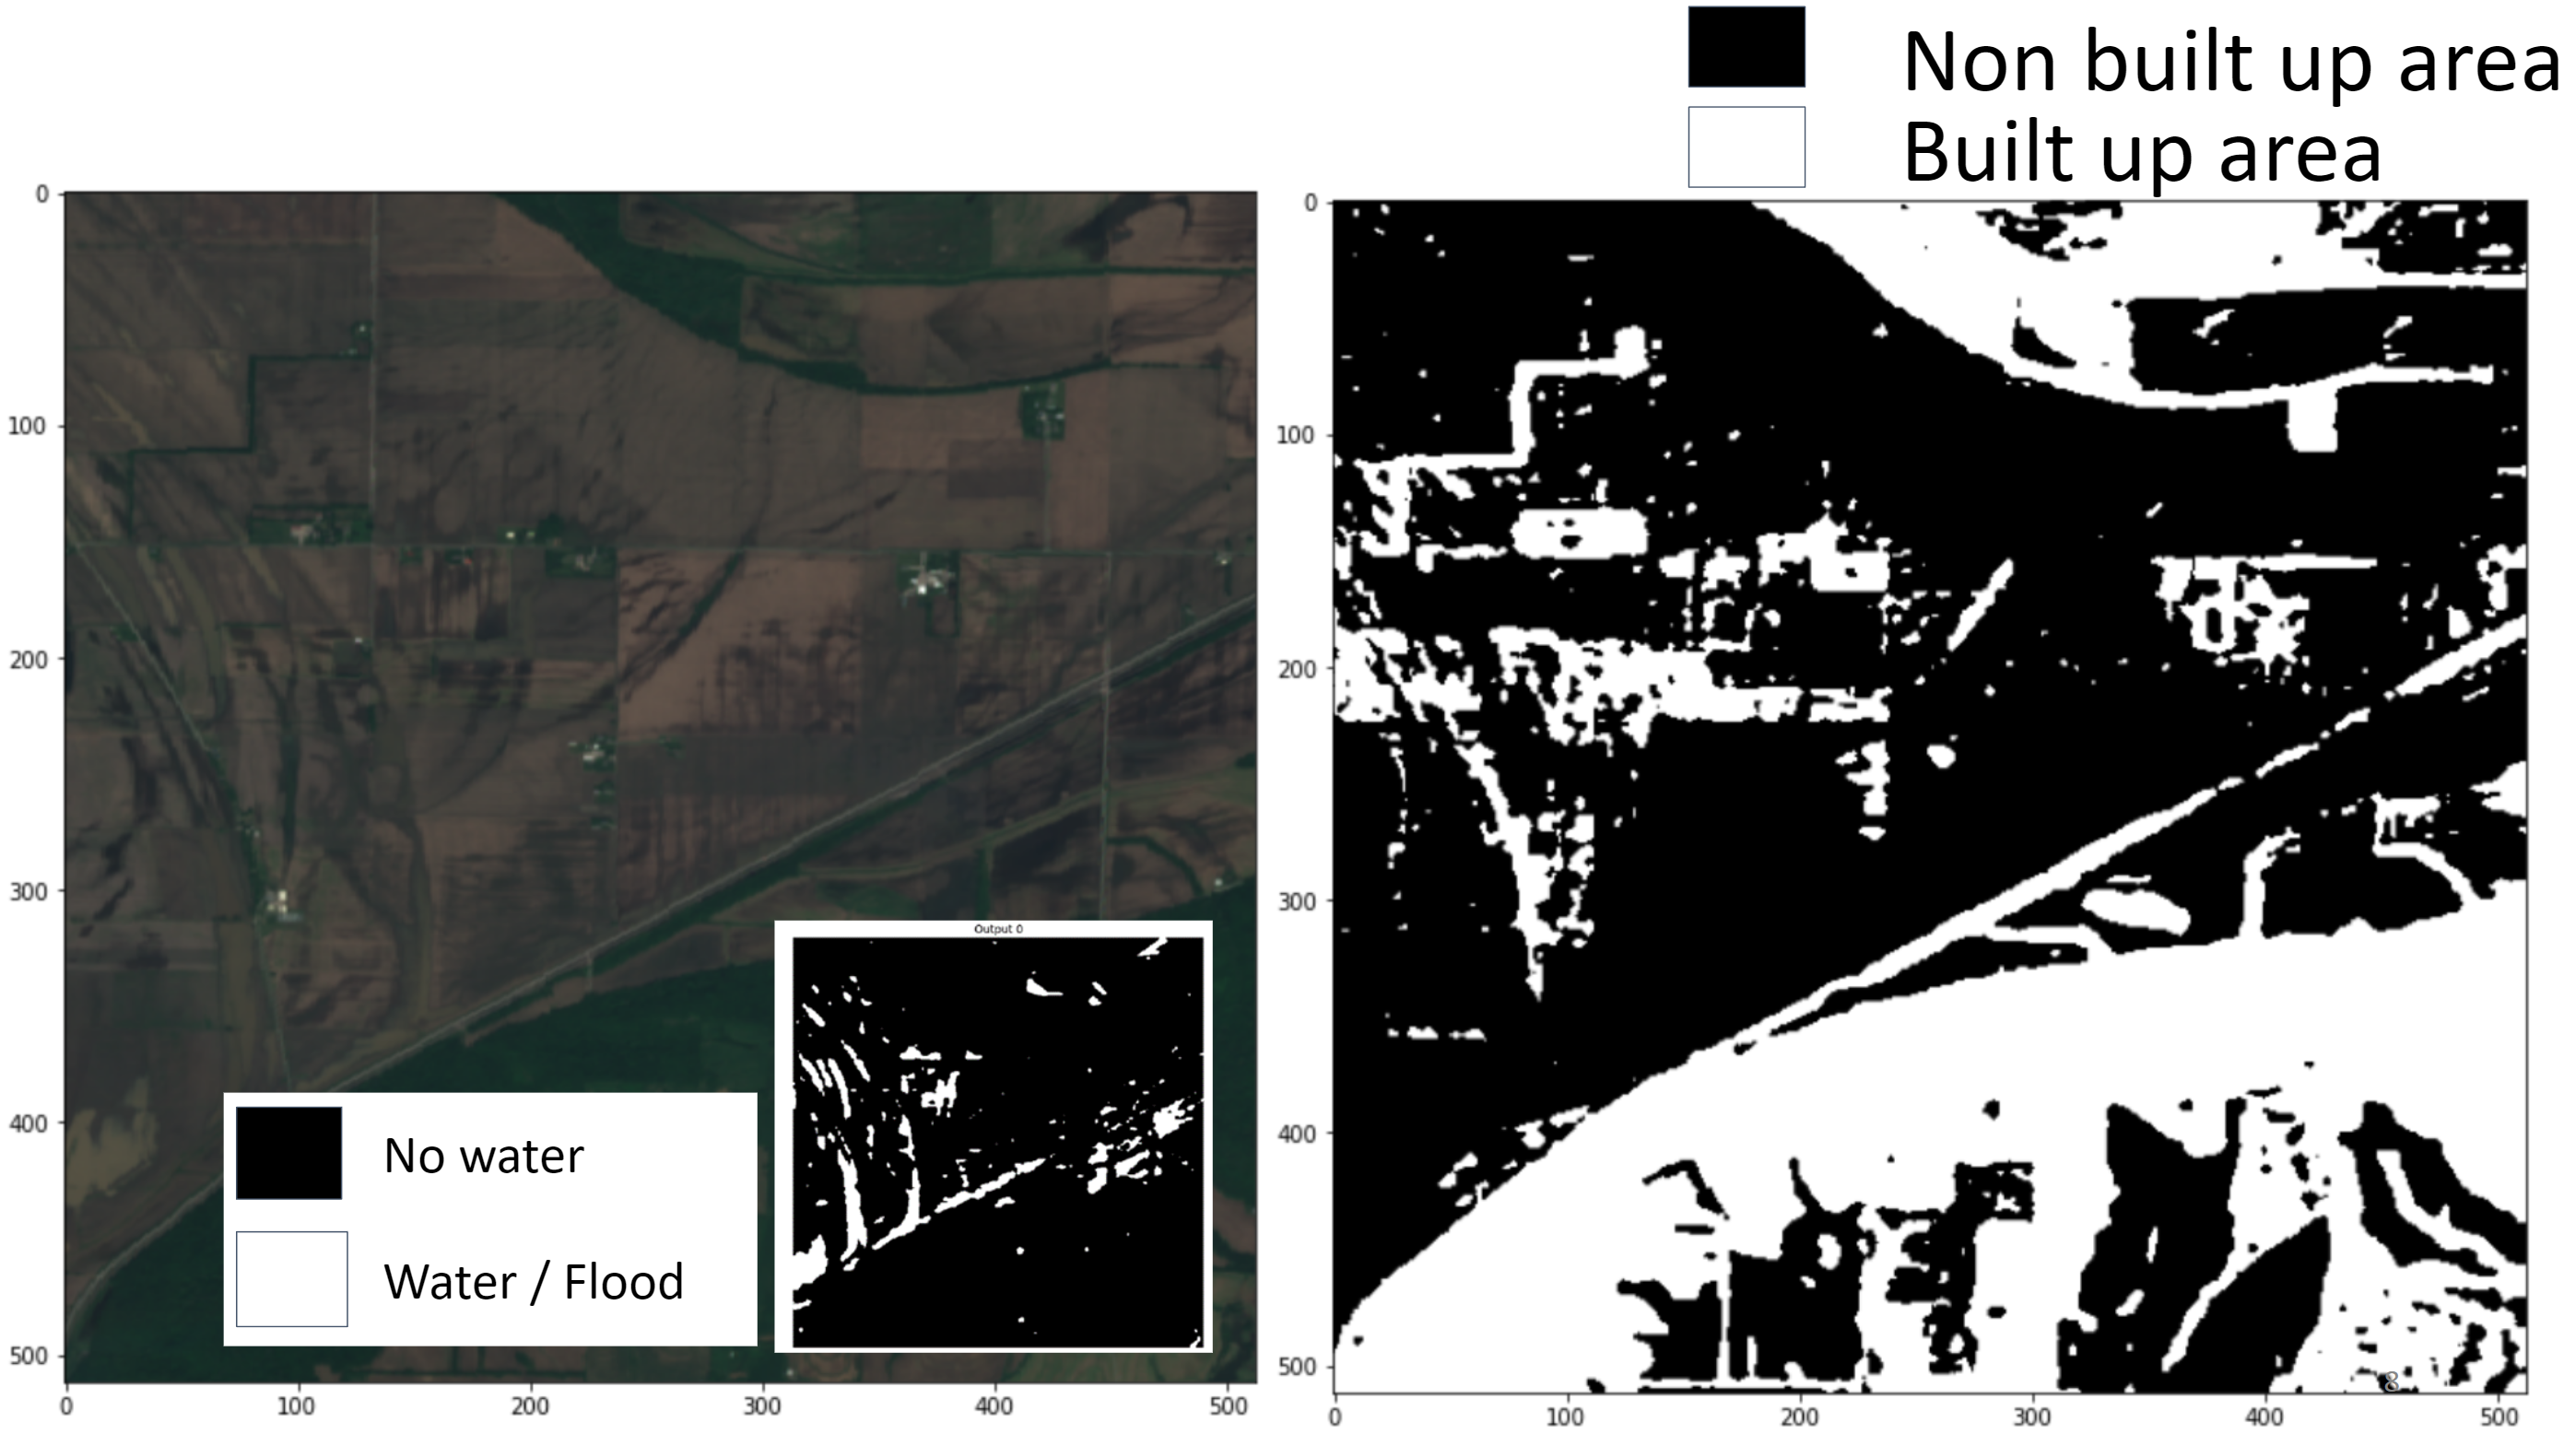


## **Data Science Ethics Checklist** <a name="ethics"></a>

[*Back to the table of content*](#Table-of-Content)

[![Deon badge](https://img.shields.io/badge/ethics%20checklist-deon-brightgreen.svg?style=popout-square)](http://deon.drivendata.org/)


### **A. Data Collection**
<input type="checkbox" name="chk" unchecked> **A.1 Informed consent**: If there are human subjects, have they given informed consent, where subjects affirmatively opt-in and have a clear understanding of the data uses to which they consent?

 <input type="checkbox" name="chk" checked> **A.2 Collection bias**: Have we considered sources of bias that could be introduced during data collection and survey design and taken steps to mitigate those?


 <input type="checkbox" name="chk" unchecked> **A.3 Limit PII exposure**: Have we considered ways to minimize exposure of personally identifiable information (PII) for example through anonymization or not collecting information that isn't relevant for analysis?

 <input type="checkbox" name="chk" checked> **A.4 Downstream bias mitigation**: Have we considered ways to enable testing downstream results for biased outcomes (e.g., collecting data on protected group status like race or gender)?

### **B. Data Storage**
 <input type="checkbox" name="chk" unchecked> **B.1 Data security**: Do we have a plan to protect and secure data (e.g., encryption at rest and in transit, access controls on internal users and third parties, access logs, and up-to-date software)?

 - Open-source datasets


 <input type="checkbox" name="chk" unchecked> **B.2 Right to be forgotten**: Do we have a mechanism through which an individual can request their personal information be removed?

 - No individual information involved


 <input type="checkbox" name="chk" checked> **B.3 Data retention plan**: Is there a schedule or plan to delete the data after it is no longer needed?


### **C. Analysis**
 <input type="checkbox" name="chk" checked> **C.1 Missing perspectives**: Have we sought to address blindspots in the analysis through engagement with relevant stakeholders (e.g., checking assumptions and discussing implications with affected communities and subject matter experts)?


 <input type="checkbox" name="chk" checked> **C.2 Dataset bias**: Have we examined the data for possible sources of bias and taken steps to mitigate or address these biases (e.g., stereotype perpetuation, confirmation bias, imbalanced classes, or omitted confounding variables)?



 <input type="checkbox" name="chk" checked> **C.3 Honest representation**: Are our visualizations, summary statistics, and reports designed to honestly represent the underlying data?

 <input type="checkbox" name="chk" unchecked> **C.4 Privacy in analysis**: Have we ensured that data with PII are not used or displayed unless necessary for the analysis?

 <input type="checkbox" name="chk" checked> **C.5 Auditability**: Is the process of generating the analysis well documented and reproducible if we discover issues in the future?

### **D. Modeling**
 <input type="checkbox" name="chk" checked> **D.1 Proxy discrimination**: Have we ensured that the model does not rely on variables or proxies for variables that are unfairly discriminatory?

 <input type="checkbox" name="chk" unchecked> **D.2 Fairness across groups**: Have we tested model results for fairness with respect to different affected groups (e.g., tested for disparate error rates)?

 <input type="checkbox" name="chk" checked> **D.3 Metric selection**: Have we considered the effects of optimizing for our defined metrics and considered additional metrics?
 - NDBI is the additional variable we used in the new model.


 <input type="checkbox" name="chk" checked> **D.4 Explainability**: Can we explain in understandable terms a decision the model made in cases where a justification is needed?


 <input type="checkbox" name="chk" checked> **D.5 Communicate bias**: Have we communicated the shortcomings, limitations, and biases of the model to relevant stakeholders in ways that can be generally understood?



### **E. Deployment**
 <input type="checkbox" name="chk" unchecked> **E.1 Redress**: Have we discussed with our organization a plan for response if users are harmed by the results (e.g., how does the data science team evaluate these cases and update analysis and models to prevent future harm)?



 <input type="checkbox" name="chk" checked> **E.2 Roll back**: Is there a way to turn off or roll back the model in production if necessary?

 <input type="checkbox" name="chk" checked> **E.3 Concept drift**: Do we test and monitor for concept drift to ensure the model remains fair over time?


 <input type="checkbox" name="chk" unchecked> **E.4 Unintended use**: Have we taken steps to identify and prevent unintended uses and abuse of the model and do we have a plan to monitor these once the model is deployed?


*Data Science Ethics Checklist generated with [deon](http://deon.drivendata.org).*

### **Citation** <a name="citation"></a>


@software{HLS_Foundation_2023,
    author          = {Jakubik, Johannes and Chu, Linsong and Fraccaro, Paolo and Bangalore, Ranjini and Lambhate, Devyani and Das, Kamal and Oliveira Borges, Dario and Kimura, Daiki and Simumba, Naomi and Szwarcman, Daniela and Muszynski, Michal and Weldemariam, Kommy and Zadrozny, Bianca and Ganti, Raghu and Costa, Carlos and Watson, Campbell and Mukkavilli, Karthik and Roy, Sujit and Phillips, Christopher and Ankur, Kumar and Ramasubramanian, Muthukumaran and Gurung, Iksha and Leong, Wei Ji and Avery, Ryan and Ramachandran, Rahul and Maskey, Manil and Olofossen, Pontus and Fancher, Elizabeth and Lee, Tsengdar and Murphy, Kevin and Duffy, Dan and Little, Mike and Alemohammad, Hamed and Cecil, Michael and Li, Steve and Khallaghi, Sam and Godwin, Denys and Ahmadi, Maryam and Kordi, Fatemeh and Saux, Bertrand and Pastick, Neal and Doucette, Peter and Fleckenstein, Rylie and Luanga, Dalton and Corvin, Alex and Granger, Erwan},
    doi             = {10.57967/hf/0952},
    month           = aug,
    title           = {{HLS Foundation}},
    repository-code = {https://github.com/nasa-impact/hls-foundation-os},
    year            = {2023}
}


[*Back to the table of content*](#Table-of-Content)